In [1]:
#Function to generate a 3-panel plot for input arrays
def plot_array(dem, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None, close_fig=True):
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    #Gray background
    ax.set_facecolor('0.5')
    #Force aspect ratio to match images
    ax.set(aspect='equal')
    #Turn off axes labels/ticks
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if titles is not None:
        ax.set_title(titles[0])
    #Plot background shaded relief map
    if overlay is not None:
        alpha = 0.7
        ax.imshow(overlay, cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [ax.imshow(dem, clim=clim, cmap=cmap, alpha=alpha)]
    fig.tight_layout()
    fig.colorbar(im_list[0], label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)
    if close_fig:
        plt.close(fig)


def nearest_nonzero_idx(a,x,y):
    r,c = np.nonzero(a)
    min_idx = ((r - x)**2 + (c - y)**2).argmin()
    return r[min_idx], c[min_idx]


def maskedarray_gt(data, value):
    """ Greater than operation on masked array to avoid warning errors """
    data = np.nan_to_num(data,0)
    data[data > value] = value
    return data


def maskedarray_lt(data, value):
    """ Less than operation on masked array to avoid warning errors """
    data = np.nan_to_num(data,0)
    data[data < value] = value
    return data


def ts_fromdebris_func(h, a, b, c):
        """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
        Hill Equation"""
        return a * h**c / (b**c + h**c)
def debris_fromts_func(ts, a, b, c):
    """ estimate debris thickness from surface temperature (ts is surface temperature, a and k are coefficients) 
    Hill Equation"""
    return (ts * b**c / (a - ts))**(1/c)

# def meltfactor_fromdebris_func(h, a, k, melt_2cm):
#     """ estimate melt factor from debris thickness (h is debris thickness, a and k are coefficients) 
#     Hill equation """
#     melt_h = a / (1 + 2 * k * a * h)
#     melt_factor = melt_h / melt_2cm
#     melt_factor[melt_factor > 1] = 1
#     return melt_factor

def debris_fromts_maskedarray(ts_raw, a, b, c):
    """ Apply debris_fromts_func to masked array
        includes a mask of maximum values, since Michaelis-Mentin Equation has natural maximum 
    Parameters
    ----------
    ts_raw : np.ma.array
        masked array of the unmodified surface temperature
    Returns
    -------
    hd : np.ma.array 
        masked array of the debris thickness (m)
    """
    ts = ts_raw.copy()
    max_value = ts_fromdebris_func(50, a, b, c)
    debris_thick_ts = np.ma.array(maskedarray_gt(ts.data, max_value), mask=np.ma.getmask(ts))
    debris_thick_ts = np.ma.array(maskedarray_lt(ts.data, 0), mask=np.ma.getmask(ts))
    hd = debris_fromts_func(ts.data, a, b, c)
    return hd


def emergence_pixels(gf, vel_x_raw, vel_y_raw, icethickness_raw, xres, yres, 
                     vel_min=0, max_velocity=600, vel_depth_avg_factor=0.8, option_border=1,
                     positive_is_east=True, positive_is_north=True, constant_icethickness=False, debug=True):
    """ Compute the emergence velocity using an ice flux approach
    """
    # Glacier mask
    glac_mask = np.zeros(vel_x_raw.shape) + 1
    glac_mask[gf.z1.mask] = 0
    
    # Replace nan with 0
    vel_x_raw = np.nan_to_num(vel_x_raw,0)
    vel_y_raw = np.nan_to_num(vel_y_raw,0)
    
    # Modify vel_y by multiplying velocity by -1 such that matrix operations agree with flow direction
    #    Specifically, a negative y velocity means the pixel is flowing south.
    #    However, if you were to subtract that value from the rows, it would head north in the matrix.
    #    This is due to the fact that the number of rows start at 0 at the top.
    #    Therefore, multipylying by -1 aligns the matrix operations with the flow direction
    if positive_is_north:
        vel_y = -1*vel_y_raw * vel_depth_avg_factor
    else:
        vel_y = vel_y_raw * vel_depth_avg_factor
    if positive_is_east:
        vel_x = vel_x_raw * vel_depth_avg_factor
    else:
        vel_x = -1*vel_x_raw * vel_depth_avg_factor
    vel_total = (vel_y**2 + vel_x**2)**0.5
    # Ice thickness
    icethickness = icethickness_raw.copy()
    if constant_icethickness:
        icethickness[:,:] = 1
        icethickness = icethickness * glac_mask
#     print('mean ice thickness:', np.round(icethickness.mean(),0), 'm')
    # Compute the initial volume
    volume_initial = icethickness * (xres * yres)
    pix_maxres = xres
    if yres > pix_maxres:
        pix_maxres = yres
    # Quality control options:
    # Apply a border based on the max specified velocity to prevent errors associated with pixels going out of bounds
    if option_border == 1:
        border = int(max_velocity / pix_maxres) + 1
        for r in range(vel_x.shape[0]):
            for c in range(vel_x.shape[1]):
                if (r < border) | (r >= vel_x.shape[0] - border) | (c < border) | (c >= vel_x.shape[1] - border):
                    vel_x[r,c] = 0
                    vel_y[r,c] = 0
    # Minimum/maximum velocity bounds
    vel_x[vel_total < vel_min] = 0
    vel_y[vel_total < vel_min] = 0
    vel_x[vel_total > max_velocity] = 0
    vel_y[vel_total > max_velocity] = 0
#     # Remove clusters of high velocity on stagnant portions of glaciers due to feature tracking of cliffs and ponds
#     if option_stagnantbands == 1:
#         vel_x[bands <= stagnant_band] = 0
#         vel_y[bands <= stagnant_band] = 0        
    # Compute displacement in units of pixels
    vel_x_pix = vel_x / xres
    vel_y_pix = vel_y / yres
    # Compute the displacement and fraction of pixels moved for all columns (x-axis)
    # col_x1 is the number of columns to the closest pixel receiving ice [ex. 2.6 returns 2, -2.6 returns -2]
    #    int() automatically rounds towards zero
    col_x1 = vel_x_pix.astype(int)
    # col_x2 is the number of columns to the further pixel receiving ice [ex. 2.6 returns 3, -2.6 returns -3]
    #    np.sign() returns a value of 1 or -1, so it's adding 1 pixel away from zero
    col_x2 = (vel_x_pix + np.sign(vel_x_pix)).astype(int)
    # rem_x2 is the fraction of the pixel that remains in the further pixel (col_x2) 
    #    [ex. 2.6 returns 0.6, -2.6 returns 0.6]
    #    np.sign() returns a value of 1 or -1, so multiplying by that ensures you have a positive value
    #    then when you take the remainder using "% 1", you obtain the desired fraction
    rem_x2 = np.multiply(np.sign(vel_x_pix), vel_x_pix) % 1
    # rem_x1 is the fraction of the pixel that remains in the closer pixel (col_x1) 
    #    [ex. 2.6 returns 0.4, -2.6 returns 0.4]
    rem_x1 = 1 - rem_x2
    # Repeat the displacement and fraction computations for all rows (y-axis)
    row_y1 = vel_y_pix.astype(int)
    row_y2 = (vel_y_pix + np.sign(vel_y_pix)).astype(int)
    rem_y2 = np.multiply(np.sign(vel_y_pix), vel_y_pix) % 1
    rem_y1 = 1 - rem_y2
          
    # Compute the mass flux for each pixel
    volume_final = np.zeros(volume_initial.shape)
    for r in range(vel_x.shape[0]):
        for c in range(vel_x.shape[1]):
            volume_final[r+row_y1[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x1[r,c]] + rem_y1[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x1[r,c]] + rem_y2[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y1[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x2[r,c]] + rem_y1[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x2[r,c]] + rem_y2[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
         
    # Redistribute off-glacier volume back onto the nearest pixel on the glacier
    offglac_row, offglac_col = np.where((glac_mask == 0) & (volume_final > 0))
    for nidx in range(0,len(offglac_row)):
        nrow = offglac_row[nidx]
        ncol = offglac_col[nidx]
        ridx, cidx = nearest_nonzero_idx(glac_mask, nrow, ncol)
        # Add off-glacier volume back onto nearest pixel on glacier
        volume_final[ridx,cidx] += volume_final[nrow,ncol]
        volume_final[nrow,ncol] = 0
            
    # Check that mass is conserved (threshold = 0.1 m x pixel_size**2)
    if debug:
        print('Mass is conserved?', np.absolute(volume_final.sum() - volume_initial.sum()) / 
              volume_initial.sum() < 0.01)
        print(np.round(np.absolute(volume_final.sum() - volume_initial.sum()),1), 
              np.round(np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() * 100,2), '%')
        
    if np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() > 0.01:
        print('MASS NOT CONSERVED FOR EMERGENCE VELOCITY')
    # Final ice thickness
    icethickness_final = volume_final / (xres * yres)
    # Emergence velocity
    emergence_velocity = icethickness_final - icethickness
    return emergence_velocity

In [2]:
#! /usr/bin/env python
"""
Compute debris thickness through sub-debris and temperature inversion methods
"""
import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import median_absolute_deviation
import xarray as xr
from osgeo import gdal, ogr, osr

from pygeotools.lib import malib, warplib, geolib, iolib, timelib
# from imview.lib import pltlib

# import globaldebris_input as input
import debrisglobal.globaldebris_input as debris_prms
from debrisglobal.glacfeat import GlacFeat

calc_emergence = True

verbose=False
debug=False
extra_layers=True

csv_ending = '_mb_bins.csv'
# outdir_csv = '/'.join(debris_prms.dhdt_fn_dict[debris_prms.roi].split('/')[:-1]) + '/binned_data/'
outdir_csv = debris_prms.mb_binned_fp
if os.path.exists(outdir_csv) == False:
    os.makedirs(outdir_csv)

In [3]:
# Debris cover extent shapefile with statistics
dc_shp = gpd.read_file(debris_prms.debriscover_fp + debris_prms.debriscover_fn_dict[debris_prms.roi])
dc_shp = dc_shp.sort_values(by=['RGIId'])

# Subset by percent debris-covered or debris-covered area
dc_shp_subset = dc_shp[((dc_shp['DC_Area__1'] > debris_prms.dc_percarea_threshold) | 
                        (dc_shp['DC_Area_v2'] / 1e6 > debris_prms.dc_area_threshold))
                        & (dc_shp['Area'] > debris_prms.min_glac_area)].copy()
dc_shp_subset.reset_index(inplace=True, drop=True)
dc_shp_subset['CenLon_360'] = dc_shp_subset['CenLon']
dc_shp_subset.loc[dc_shp_subset['CenLon_360'] < 0, 'CenLon_360'] = (
    360 + dc_shp_subset.loc[dc_shp_subset['CenLon_360'] < 0, 'CenLon_360'])
print(dc_shp_subset.RGIId.values)
dc_shp_subset

['RGI60-11.00002' 'RGI60-11.00047' 'RGI60-11.00054' 'RGI60-11.00068'
 'RGI60-11.00106' 'RGI60-11.00110' 'RGI60-11.00116' 'RGI60-11.00135'
 'RGI60-11.00141' 'RGI60-11.00190' 'RGI60-11.00199' 'RGI60-11.00233'
 'RGI60-11.00278' 'RGI60-11.00376' 'RGI60-11.00415' 'RGI60-11.00459'
 'RGI60-11.00469' 'RGI60-11.00487' 'RGI60-11.00524' 'RGI60-11.00541'
 'RGI60-11.00597' 'RGI60-11.00719' 'RGI60-11.00781' 'RGI60-11.00797'
 'RGI60-11.00830' 'RGI60-11.00846' 'RGI60-11.00871' 'RGI60-11.00886'
 'RGI60-11.00887' 'RGI60-11.00897' 'RGI60-11.00918' 'RGI60-11.00929'
 'RGI60-11.00932' 'RGI60-11.00943' 'RGI60-11.00945' 'RGI60-11.00950'
 'RGI60-11.00957' 'RGI60-11.00958' 'RGI60-11.01144' 'RGI60-11.01187'
 'RGI60-11.01193' 'RGI60-11.01246' 'RGI60-11.01275' 'RGI60-11.01296'
 'RGI60-11.01328' 'RGI60-11.01346' 'RGI60-11.01450' 'RGI60-11.01478'
 'RGI60-11.01509' 'RGI60-11.01550' 'RGI60-11.01576' 'RGI60-11.01604'
 'RGI60-11.01621' 'RGI60-11.01622' 'RGI60-11.01678' 'RGI60-11.01698'
 'RGI60-11.01719' 'RGI60-11.01776'

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,DC_Area,DC_BgnDate,DC_EndDate,DC_CTSmean,DC_Area_%,area_singl,DC_Area_v2,DC_Area__1,geometry,CenLon_360
0,RGI60-11.00002,G013614E47485N,20030799,20030999,13.614373,47.483905,11,1,2.292,2203,...,186300,2013,2017,29.698587,8.128,900,186399,8.133,"MULTIPOLYGON (((13.60653 47.47813, 13.60692 47...",13.614373
1,RGI60-11.00047,G012719E47139N,20030799,20030999,12.718158,47.139499,11,1,2.273,2307,...,152100,2013,2017,20.334521,6.692,900,156609,6.890,"MULTIPOLYGON (((12.70776 47.13999, 12.70815 47...",12.718158
2,RGI60-11.00054,G012372E47149N,20030799,20030999,12.370435,47.149801,11,1,2.274,2359,...,143100,2013,2017,17.590514,6.293,900,143075,6.292,"MULTIPOLYGON (((12.35997 47.14789, 12.36037 47...",12.370435
3,RGI60-11.00068,G012345E47132N,20030799,20030999,12.343717,47.135779,11,1,2.738,2162,...,176400,2013,2017,18.493408,6.443,900,176364,6.441,"MULTIPOLYGON (((12.35453 47.12994, 12.35493 47...",12.343717
4,RGI60-11.00106,G012697E47099N,20030799,20030999,12.698172,47.094468,11,1,17.774,2086,...,2984400,2013,2017,23.575460,16.791,4500,3036802,17.086,"MULTIPOLYGON (((12.70993 47.08010, 12.71112 47...",12.698172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,RGI60-11.03694,G006263E44892N,20030813,-9999999,6.259492,44.893911,11,1,2.242,2405,...,813600,2013,2017,42.305511,36.289,900,814213,36.316,"MULTIPOLYGON (((6.25929 44.88545, 6.25967 44.8...",6.259492
152,RGI60-11.03698,G006988E45987N,20030813,-9999999,6.995296,45.985482,11,1,8.124,2193,...,573300,2013,2017,38.465296,7.057,5401,577015,7.103,"MULTIPOLYGON (((7.00593 45.96921, 7.00709 45.9...",6.995296
153,RGI60-11.03701,G007144E45371N,20030813,-9999999,7.145103,45.375305,11,1,2.373,2761,...,403200,2013,2017,38.446785,16.991,900,404213,17.034,"MULTIPOLYGON (((7.15623 45.36957, 7.15661 45.3...",7.145103
154,RGI60-11.03740,G007123E45253N,20030813,-9999999,7.118216,45.254020,11,1,2.067,2773,...,453600,2013,2017,41.382340,21.945,1800,464972,22.495,"MULTIPOLYGON (((7.12013 45.24476, 7.12090 45.2...",7.118216


In [4]:
rgiid_list = [x.split('-')[1] for x in dc_shp_subset['RGIId'].values]
main_glac_rgi_subset = debris_prms.selectglaciersrgitable(rgiid_list)
main_glac_rgi_subset

156 glaciers in region 11 are included in this model run: ['00002', '00047', '00054', '00068', '00106', '00110', '00116', '00135', '00141', '00190', '00199', '00233', '00278', '00376', '00415', '00459', '00469', '00487', '00524', '00541', '00597', '00719', '00781', '00797', '00830', '00846', '00871', '00886', '00887', '00897', '00918', '00929', '00932', '00943', '00945', '00950', '00957', '00958', '01144', '01187', '01193', '01246', '01275', '01296', '01328', '01346', '01450', '01478', '01509', '01550'] and more
This study is focusing on 156 glaciers in region [11]


,O1Index,RGIId,CenLon,CenLat,O1Region,O2Region,Area,Zmin,Zmax,Zmed,Slope,Aspect,Lmax,Form,TermType,Surging,RefDate,glacno,rgino_str,RGIId_float
GlacNo,,,,,,,,,,,,,,,,,,,,
0,1,RGI60-11.00002,13.613500,47.484500,11,1,2.292,2203,2855,2526,18.6,49,1853,0,0,9,20039999,2,11.00002,11.00002
1,46,RGI60-11.00047,12.719400,47.138600,11,1,2.273,2307,3253,2967,21.1,342,2336,0,0,9,20039999,47,11.00047,11.00047
2,53,RGI60-11.00054,12.371700,47.148700,11,1,2.274,2359,3196,2779,27.1,17,1765,0,0,9,20039999,54,11.00054,11.00054
3,67,RGI60-11.00068,12.345300,47.132200,11,1,2.738,2162,3440,2759,15.2,347,5390,0,0,9,20039999,68,11.00068,11.00068
4,105,RGI60-11.00106,12.696700,47.099100,11,1,17.774,2086,3487,2984,15.9,112,8667,0,0,9,20039999,106,11.00106,11.00106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,3693,RGI60-11.03694,6.263000,44.892000,11,1,2.242,2405,3301,2839,31.9,18,1678,0,0,9,20030813,3694,11.03694,11.03694
152,3697,RGI60-11.03698,6.988000,45.987000,11,1,8.124,2193,3707,2977,19.0,309,4112,0,0,9,20030813,3698,11.03698,11.03698
153,3700,RGI60-11.03701,7.144000,45.371000,11,1,2.373,2761,3340,3046,16.5,285,1706,0,0,9,20030813,3701,11.03701,11.03701


In [5]:
# np.where(main_glac_rgi_subset.rgino_str == '15.03473')

0 120 RGI60-11.03005


HACK TO BYPASS VALID AREA




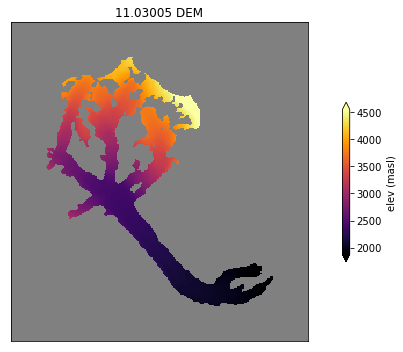

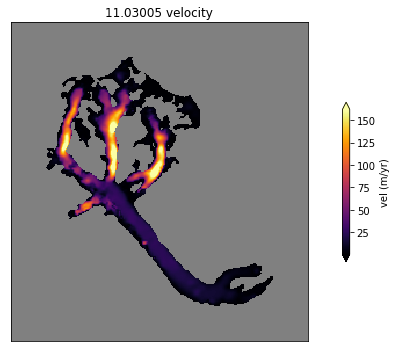

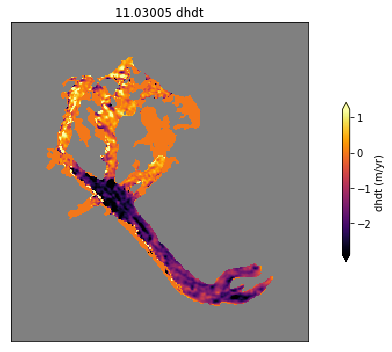

In [8]:
# ===== PROCESS EACH GLACIER =====
# for nglac, glac_idx in enumerate(main_glac_rgi_subset.index.values):
for nglac, glac_idx in enumerate([main_glac_rgi_subset.index.values[120]]): # Miage
# for nglac, glac_idx in enumerate([main_glac_rgi_subset.index.values[2307]]): # Ngozumpa

    glac_str = main_glac_rgi_subset.loc[glac_idx,'rgino_str']
    rgiid = main_glac_rgi_subset.loc[glac_idx,'RGIId']
    region = glac_str.split('.')[0]

    if int(region) < 10:
        glac_str_noleadzero = str(int(glac_str.split('.')[0])) + '.' + glac_str.split('.')[1]
    else:
        glac_str_noleadzero = glac_str

    if os.path.exists(debris_prms.hd_fp + debris_prms.hd_fn_sample.replace('XXXX',glac_str_noleadzero)) == False:

        print(nglac, glac_idx, rgiid)

        # ===== Project shapefile =====
        thick_dir = debris_prms.oggm_fp + 'thickness/RGI60-' + str(region.zfill(2)) + '/'
        thick_fn = rgiid + '_thickness.tif'

        proj_fn = os.path.join(thick_dir, thick_fn) # THIS PROJECTION IS KEY!
        ds = gdal.Open(proj_fn)
        prj = ds.GetProjection()
        srs = osr.SpatialReference(wkt=prj)
        aea_srs = srs

        # Shape layer processing
        # If projected shapefile already exists, then skip projection
        glac_shp_proj_fn = (debris_prms.glac_shp_proj_fp + glac_str + '_crs' + 
                            str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp')
        dc_shp_proj_fn = (debris_prms.glac_shp_proj_fp + glac_str + '_dc_crs' + 
                          str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp')
        if os.path.exists(glac_shp_proj_fn) == False:
            glac_shp_init = gpd.read_file(debris_prms.glac_shp_fn_dict[region])
            if verbose:
                print('Shp init crs:', glac_shp_init.crs)
            glac_shp_single = glac_shp_init[glac_shp_init['RGIId'] == rgiid]
            glac_shp_single = glac_shp_single.reset_index()
            glac_shp_proj = glac_shp_single.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
            glac_shp_proj.to_file(glac_shp_proj_fn)

        if os.path.exists(dc_shp_proj_fn) == False:
            dc_shp_init = gpd.read_file(debris_prms.debriscover_fp + debris_prms.debriscover_fn_dict[debris_prms.roi])
            dc_shp_single = dc_shp_init[dc_shp_init['RGIId'] == rgiid]
            dc_shp_single = dc_shp_single.reset_index()
            dc_shp_proj = dc_shp_single.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
            dc_shp_proj.to_file(dc_shp_proj_fn)

        glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
        glac_shp_lyr = glac_shp_ds.GetLayer()
        #This should be contained in features
        glac_shp_srs = glac_shp_lyr.GetSpatialRef()
        feat_count = glac_shp_lyr.GetFeatureCount()
        if verbose:
            print("Input glacier polygon count: %i" % feat_count)

        dc_shp_ds = ogr.Open(dc_shp_proj_fn, 0)
        dc_shp_lyr = dc_shp_ds.GetLayer()
        #This should be contained in features
        dc_shp_srs = dc_shp_lyr.GetSpatialRef()
        feat_count = dc_shp_lyr.GetFeatureCount()
        if verbose:
            print("Input glacier polygon count (debris cover): %i" % feat_count)

        # Load DEM
        z1_dir = debris_prms.oggm_fp + 'dems/RGI60-' + str(region.zfill(2)) + '/'
        z1_fn = rgiid + '_dem.tif'
        z1_ds = gdal.Open(z1_dir + z1_fn)
        z1_int_geom = geolib.ds_geom_intersection([z1_ds, z1_ds], t_srs=glac_shp_srs)

        glacname_fieldname = "Name"
        glacnum_fieldname = "RGIId"
        glacnum_fmt = '%08.5f'

        for n, feat in enumerate(glac_shp_lyr):
            gf = GlacFeat(feat, glacname_fieldname, glacnum_fieldname)
            if verbose:
                print("%i of %i: %s" % (n+1, feat_count, gf.feat_fn))
            #NOTE: Input must be in projected coordinate system, ideally equal area
            #Should check this and reproject
            gf.geom_attributes(srs=aea_srs)

        if verbose:
            print(gf.feat_fn)

        fn_dict = OrderedDict()
        #We at least want to warp the two input DEMs
        fn_dict['z1'] = os.path.join(z1_dir, z1_fn)

        if extra_layers and (gf.glac_area_km2 > debris_prms.min_glac_area_writeout):
            if verbose:
                print(gf.glacnum)
                
            dhdt_fn = debris_prms.dhdt_fn_dict[debris_prms.roi]
            if dhdt_fn is not None:
                fn_dict['dhdt'] = dhdt_fn

            # Ice thickness data
            ice_thick_fn = os.path.join(thick_dir, thick_fn)
            if os.path.exists(ice_thick_fn):
                fn_dict['ice_thick'] = ice_thick_fn

            if os.path.exists(debris_prms.v_dir + debris_prms.vx_fn_dict[debris_prms.roi]):
                fn_dict['vx'] = debris_prms.v_dir + debris_prms.vx_fn_dict[debris_prms.roi]
                fn_dict['vy'] = debris_prms.v_dir + debris_prms.vy_fn_dict[debris_prms.roi]

            if os.path.exists(debris_prms.ts_fp + debris_prms.ts_fn_dict[debris_prms.roi]):
                fn_dict['ts'] = debris_prms.ts_fp + debris_prms.ts_fn_dict[debris_prms.roi]


        #Expand extent to include buffered region around glacier polygon
        warp_extent = geolib.pad_extent(gf.glac_geom_extent, width=debris_prms.buff_dist)
        if verbose:
            print("Expanding extent")
            print(gf.glac_geom_extent)
            print(warp_extent)
            print(aea_srs)

        #Warp everything to common res/extent/proj
        z1_gt = gdal.Open(fn_dict['z1']).GetGeoTransform()
        z1_res = np.min([z1_gt[1], -z1_gt[5]])
        ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res=z1_res, \
                extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
                r='cubic')
        ds_dict = dict(zip(fn_dict.keys(), ds_list))

        if verbose:
            print(ds_list)
            print(fn_dict.keys())

        #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
        glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
        glac_shp_lyr = glac_shp_ds.GetLayer()
        dc_shp_ds = ogr.Open(dc_shp_proj_fn, 0)
        dc_shp_lyr = dc_shp_ds.GetLayer()

        #Get global glacier mask
        #Want this to be True over ALL glacier surfaces, not just the current polygon
        glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['ice_thick'])
        dc_shp_lyr_mask = geolib.lyr2mask(dc_shp_lyr, ds_dict['ice_thick'])

        #Create buffer around glacier polygon
        glac_geom_buff = gf.glac_geom.Buffer(debris_prms.buff_dist)
        #This is False over glacier polygon surface, True elsewhere - can be applied directly
        glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['ice_thick'])

        # ds masks
        ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
        dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
        dems_mask = dem1.mask
        if verbose:
            print('list of datasets:', len(ds_list_masked), fn_dict.values())

        #Combine to identify ~1 km buffer around glacier polygon over static rock
        static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
        static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

        if 'z1' in ds_dict:
            #This is False over glacier polygon surface, True elsewhere - can be applied directly
            glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1'])
            gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']))
            #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)
            
            gf.res = geolib.get_res(ds_dict['z1'])

            # Debris cover
            dc_mask = np.ma.mask_or(dc_shp_lyr_mask, glac_geom_mask)
            gf.dc_area = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=dc_mask)

            if verbose:
                print('\n\n# z1 pixels:', gf.z1.count(), '\n')
            if gf.z1.count() == 0:
                if verbose:
                    print("No z1 pixels")
        else:
            print("Unable to load z1 ds")

        # ===== ADD VARIOUS LAYERS TO gf =====
        if nglac == 0:
            print('\n\nHACK TO BYPASS VALID AREA\n\n')
        gf.valid_area_perc = 100

        if gf.valid_area_perc < (100. * debris_prms.min_valid_area_perc):
            if verbose:
                print("Not enough valid pixels. %0.1f%% percent of glacier polygon area" % (gf.valid_area_perc))
        #     return None

        else:
            #Filter dz - throw out abs differences >150 m

            #Compute dz, volume change, mass balance and stats
            gf.z1_stats = malib.get_stats(gf.z1)
            z1_elev_med = gf.z1_stats[5]
            z1_elev_min, z1_elev_max = malib.calcperc(gf.z1, (0.1, 99.9))

            #Caluclate stats for aspect and slope using z2
            #Requires GDAL 2.1+
            gf.z1_aspect = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='aspect', returnma=True), 
                                       mask=glac_geom_mask)
            gf.z1_aspect_stats = malib.get_stats(gf.z1_aspect)
            z1_aspect_med = gf.z1_aspect_stats[5]
            gf.z1_slope = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='slope', returnma=True), 
                                      mask=glac_geom_mask)
            gf.z1_slope_stats = malib.get_stats(gf.z1_slope)
            z1_slope_med = gf.z1_slope_stats[5]

            #Can estimate ELA values computed from hypsometry and typical AAR
            #For now, assume ELA is mean
            gf.z1_ela = None
            gf.z1_ela = gf.z1_stats[3]
            #Note: in theory, the ELA should get higher with mass loss
            #In practice, using mean and same polygon, ELA gets lower as glacier surface thins

            # copy for Ts because it change the mask otherwise and messes up binned statistics for whole glacier
            glac_geom_mask_copy = glac_geom_mask.copy()
            
            gf.z1 = np.ma.array(gf.z1, mask=glac_geom_mask)

            if extra_layers and (gf.glac_area_km2 > debris_prms.min_glac_area_writeout):
                if 'ice_thick' in ds_dict:
                    #Load ice thickness
                    gf.H = np.ma.array(iolib.ds_getma(ds_dict['ice_thick']), mask=glac_geom_mask)
                    gf.H_mean = gf.H.mean()
                    if verbose:
                        print('mean ice thickness [m]:', gf.H_mean)

                if 'vx' in ds_dict and 'vy' in ds_dict:
                    #Load surface velocity maps
                    gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask)
                    gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask)
                    gf.vm = np.ma.sqrt(gf.vx**2 + gf.vy**2)
                    gf.vm_mean = gf.vm.mean()
                    if verbose:
                        print('mean velocity [m/s]:', gf.vm_mean)

                    if gf.H is not None:
                        #Compute flux
                        gf.Q = gf.H * debris_prms.v_col_f * np.array([gf.vx, gf.vy])
                        #Note: np.gradient returns derivatives relative to axis number, so (y, x) in this case
                        #Want x-derivative of x component
                        gf.divQ = np.gradient(gf.Q[0])[1] + np.gradient(gf.Q[1])[0]

        #                 gf.divQ = gf.H*(np.gradient(v_col_f*gf.vx)[1] + np.gradient(v_col_f*gf.vy)[0]) \
        #                         + v_col_f*gf.vx*(np.gradient(gf.H)[1]) + v_col_f*gf.vy*(np.gradient(gf.H)[0])

                        #Should smooth divQ, better handling of data gaps
            
                # Emergence velocity
                if calc_emergence and 'vx' in ds_dict and 'vy' in ds_dict and gf.H is not None:
                    vx = np.ma.filled(gf.vx,0)
                    vy = np.ma.filled(gf.vy,0)
                    H = np.ma.filled(gf.H,0)
                    vx[gf.z1 > gf.z1.max()] = 0
                    vy[gf.z1 > gf.z1.max()] = 0
                    H[gf.z1 > gf.z1.max()] = 0
                    vmax = np.nanmax((vx**2 + vy**2)**0.5)

                    # Emergence computation
                    emvel = emergence_pixels(gf, vx, vy, H, gf.res[0], gf.res[1], 
                                             positive_is_east=True, positive_is_north=True, 
                                             constant_icethickness=False, max_velocity=vmax, vel_min=0, debug=False)
                    # 3x3 filter to reduce
                    if debris_prms.emvel_filter_pixsize > 0:
                        emvel = ndimage.filters.convolve(
                            emvel, weights=np.full((debris_prms.emvel_filter_pixsize, 
                                                    debris_prms.emvel_filter_pixsize), 
                                                    1.0/debris_prms.emvel_filter_pixsize**2))
                    # Add to glacier feature
                    gf.emvel = np.ma.masked_array(emvel, mask=np.ma.getmask(gf.z1))

                if 'ts' in ds_dict:
                    #Load surface temperature maps
                    gf.ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask_copy)
                    gf.ts.mask = np.ma.mask_or(glac_geom_mask, 
                                               np.ma.getmask(np.ma.masked_array(gf.ts.data, np.isnan(gf.ts.data))))
                else:
                    gf.ts = None
                    
                if 'dhdt' in ds_dict:
                    gf.dhdt = np.ma.array(iolib.ds_getma(ds_dict['dhdt']), mask=glac_geom_mask_copy)
                    gf.dhdt.mask = np.ma.mask_or(
                        glac_geom_mask, np.ma.getmask(np.ma.masked_array(gf.dhdt.data, np.isnan(gf.dhdt.data))))
                    gf.mb = gf.dhdt.copy() * debris_prms.density_ice / debris_prms.density_water
                    
                    # Debris only
                    gf.dc_dhdt = np.ma.array(iolib.ds_getma(ds_dict['dhdt']), mask=glac_geom_mask_copy)
                    gf.dc_dhdt.mask = dc_mask
                    gf.dc_mb = gf.dc_dhdt.copy() * debris_prms.density_ice / debris_prms.density_water

                if 'debris_thick_ts' in ds_dict:
                    # Load debris thickness map
                    gf.debris_thick_ts = np.ma.array(
                        iolib.ds_getma(ds_dict['debris_thick_ts']), mask=glac_geom_mask_copy)
                    gf.meltfactor_ts = None
                else:
                    gf.debris_thick_ts = None
                    gf.meltfactor_ts = None

            if verbose:
                print('Area [km2]:', gf.glac_area / 1e6)
                print('-------------------------------')

            # ===== PLOTS =====
            titles = [glac_str + ' DEM']
            var_full2plot = gf.z1.copy()
            clim = malib.calcperc(var_full2plot, (2,98))
            plot_array(var_full2plot, clim, titles, 'inferno', 'elev (masl)', 
                       close_fig=False)
            
            titles = [glac_str + ' velocity']
            var_full2plot = (gf.vx.copy()**2 + gf.vy.copy()**2)**0.5
            clim = malib.calcperc(var_full2plot, (2,98))
            plot_array(var_full2plot, clim, titles, 'inferno', 'vel (m/yr)', 
                       close_fig=False)
            
#             titles = [glac_str + ' emvel']
#             var_full2plot = gf.emvel.copy()
#             clim = malib.calcperc(var_full2plot, (2,98))
#             plot_array(var_full2plot, clim, titles, 'inferno', 'emvel (m/yr)', 
#                        close_fig=False)
            
#             titles = [glac_str + ' Ts']
#             var_full2plot = gf.ts.copy()
#             clim = malib.calcperc(var_full2plot, (2,98))
#             plot_array(var_full2plot, clim, titles, 'inferno', 'ts (degC)', 
#                        close_fig=False)
            
            titles = [glac_str + ' dhdt']
            var_full2plot = gf.dhdt.copy()
            clim = malib.calcperc(var_full2plot, (2,98))
            plot_array(var_full2plot, clim, titles, 'inferno', 'dhdt (m/yr)', 
                       close_fig=False)

            # Bin data
            outbins_df, z_bin_edges = gf.hist_plot(bin_width=debris_prms.mb_bin_size, 
#                                                    exportcsv=True, outdir_csv=outdir_csv, csv_ending=csv_ending
                                                  )
            # Export binned data
            if int(gf.feat_fn.split('.')[0]) < 10:
                outbins_fullfn = os.path.join(outdir_csv, gf.feat_fn[0:7] + csv_ending)
            else:
                outbins_fullfn = os.path.join(outdir_csv, gf.feat_fn[0:8] + csv_ending)
            outbins_df.loc[:,:] = np.nan_to_num(outbins_df.loc[:,:],0)
            outbins_df.to_csv(outbins_fullfn, index=False)

In [ ]:
# ===== OLD CHECK DEM FOR ERRORS AND REPLACE SCRIPT (no longer needed with OGGM processing) =====
#             # Check if DEM has huge errors or not - replace if necessary
#             if input.roi in ['01']:

#                 gf.z1_check = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)
#                 if gf.z1_check.min() < 0:

#                     # Add backup DEM for regions with known poor quality (ex. Alaska)
#                     print('switching DEMs')
#                     fn_dict['z1_backup'] = input.z1_backup_dict[input.roi]
#                     # Warp everything to common res/extent/proj (a second time)
#                     ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res=z1_res, \
#                             extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
#                             r='cubic')
#                     ds_dict = dict(zip(fn_dict.keys(), ds_list))

#                     if verbose:
#                         print(ds_list)
#                         print(fn_dict.keys())

#                     # ds masks
#                     ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
#                     dem1 = np.ma.masked_less_equal(ds_list_masked[-1], 0)
#                     dems_mask = dem1.mask
#                     if verbose:
#                         print('list of datasets:', len(ds_list_masked), fn_dict.values())

#                     #Combine to identify ~1 km buffer around glacier polygon over static rock
#                     static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
#                     static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

#                     #This is False over glacier polygon surface, True elsewhere - can be applied directly
#                     glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1_backup'])
#                     gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1_backup']), mask=glac_geom_mask)
#                     #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)

#                     # Debris cover
#                     dc_mask = np.ma.mask_or(dc_shp_lyr_mask, glac_geom_mask)
#                     gf.dc_area = np.ma.array(iolib.ds_getma(ds_dict['z1_backup']), mask=dc_mask)